# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)

## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts)
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    NOISE = 0
    
    def __init__(self, eps=0.5, min_pts=4):
        self.eps = eps
        self.min_pts = min_pts
        
        self.visited_points = set()    # посещённые точки
        self.clusters = {self.NOISE: []}    # словарь вида "кластер -> список точек"  
        self.clustered_points = set()  # множество точек, которые отнесены к какому-либо кластеру

        
    # Обучаем модель - находим кластер для объектов в x
    def fit(self, x, y=None):
        self.x_len = len(x)       # количество точек в наборе данных
        
        # для ускорения поиска соседних точек построим k-d дерево
        self.kd_tree = ss.KDTree(x)
        self.DBSCAN(x, self.eps, self.min_pts)
        
        return self
    
    
    # Определяем кластер для всех объектов из x
    def predict(self, x):
        result = np.empty([self.x_len,], dtype=np.int8)   
        for cluster in self.clusters:  # обходим список кластеров
            points = self.clusters[cluster]  # обходим список точек для каждого кластера
            for point in points:
                result[point] = cluster
        return result
   

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    
    
    # x - набор точек, eps - радиус, min_pts - минимальное кол-во близки соседних точек,
    # необходимое, чтобы отнести точку к классу core
    def DBSCAN(self, x, eps, min_pts):
        C = 0  # инициализируем начальный кластер нулём
        
        # Обходим список точек (в случайном порядке)
        points = list(range(self.x_len))
        random.shuffle(points)   
        for point in points:  
            if point in self.visited_points:
                continue
            
            self.visited_points.add(point)
            
            neighbor_pts = self.region_query(x[point, :], eps, min_pts)
            if len(neighbor_pts) < min_pts:  # если соседних близких точек мало, то переходим к следующей точке
                self.clusters[self.NOISE].append(point)
            else:
                C += 1  # создаём новый кластер
                self.expand_cluster(x, point, neighbor_pts, C, eps, min_pts)
    
    
    # обходим соседей точки point
    def expand_cluster(self, x, point, neighbor_pts, C, eps, min_pts):  
        if C not in self.clusters:
            self.clusters[C] = []         # инициализируем кластер пустым списком
        self.clusters[C].append(point)    # и добавляем в него единственного обитателя - точку point
        self.clustered_points.add(point)
        
        while len(neighbor_pts) > 0:
            Q = neighbor_pts.pop()     # Q - сосед
            if Q not in self.visited_points:
                self.visited_points.add(Q)
                Q_neighbor_pts = self.region_query(x[Q, :], eps, min_pts)  # соседи Q
                if len(Q_neighbor_pts) >= min_pts:        # если Q - корневой объект, то его соседи добавляются
                    neighbor_pts.extend(Q_neighbor_pts)   # в список обхода
            if Q not in self.clustered_points:  # если Q ещё не член какого-то кластера, до добавляем
                self.clustered_points.add(Q)    # его в кластер C    
                self.clusters[C].append(Q)
                if Q in self.clusters[self.NOISE]:
                    self.clusters[self.NOISE].remove(Q)

    
    # найти список точек, ближайших к заданной, для которых расстояние от неё <= eps
    def region_query(self, point, eps, min_pts):
        # массив "расстояний до" и id соседних точек (включая рассматриваемую точку)
        dist, neighbors_pts = self.kd_tree.query(point, k=min_pts + 1)
        # исключаем саму рассматриваемую точку, оставляя только соседние
        dist = dist[1:]; neighbors_pts = neighbors_pts[1:]
        return neighbors_pts[dist <= eps].tolist()
    
    
    # найти среднее расстояние по m ближайшим соседям для всех точек в x
    @staticmethod
    def mean_dist_by_nearest_neighbors(x, m):
        kd_tree = ss.KDTree(x)
        mean_dist = []
        for point in range(len(x)):
            dist, neighbors_pts = kd_tree.query(x[point, :], k=m+1)
            dist = dist[1:]
            mean_dist.append(dist.mean())
        return mean_dist

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

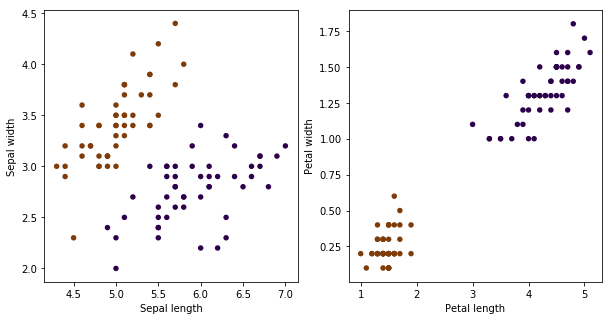

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [4]:
# Путём ручного подбора параметров eps и min_pts удалось добиться значения метрики 0.82
model = Clustering(eps=0.6, min_pts=7)
pred_iris = model.fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.82


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

Будем варьировать количество точек min_pts от 3-х до 9-ти, и строить график среднего расстояния
до m ближайших соседенй для каждой точки. По перегибу графика на глаз определяем eps

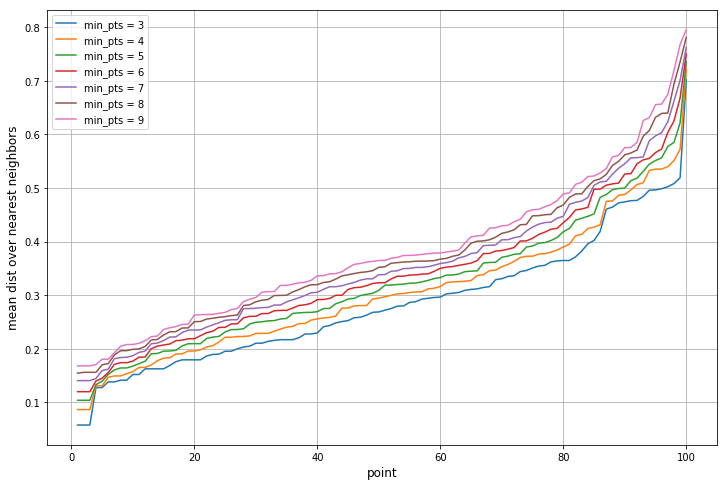

In [5]:
min_pts_list = [3, 4, 5, 6, 7, 8, 9]

fig = plt.figure(figsize=(12, 8))

plt.xlabel('point', fontsize=12)
plt.ylabel('mean dist over nearest neighbors', fontsize=12)

x = list(range(1, len(x_iris) + 1))

for min_pts in min_pts_list:
    mean_dist = Clustering.mean_dist_by_nearest_neighbors(x_iris, min_pts)
    mean_dist_sort = sorted(mean_dist)
    plt.plot(x, mean_dist_sort, label='min_pts = %d' % min_pts)
    
plt.grid()
plt.legend()
plt.show()

Видим, что заметный перегиб графика наступает где-то при eps = 0.5 ... 0.8. Фактически от количества ближайших точек характер графика не зависит

In [6]:
def quality(x, y):
    return smt.adjusted_rand_score(y_iris, y)

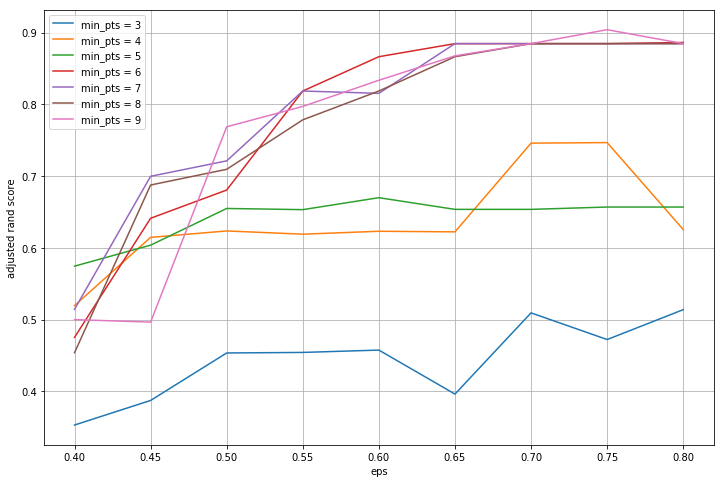

In [7]:
min_pts_list = [3, 4, 5, 6, 7, 8, 9]
eps_list = [0.4, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]

fig = plt.figure(figsize=(12, 8))

plt.xlabel("eps")
plt.ylabel("adjusted rand score")

for min_pts in min_pts_list:
    criteria = np.zeros(len(eps_list))

    for i, eps in enumerate(eps_list):
        cls = Clustering(min_pts=min_pts, eps=eps)
        y = cls.fit_predict(x_iris)
        criteria[i] = quality(x_iris, y)
        
    plt.plot(eps_list, criteria, label='min_pts = %d' % min_pts)

plt.grid()
plt.legend()
plt.show()

Отсюда видно, что наилучшее качество кластеризации при использовании DBSCAN для ирисов Фишера достигается при min_pts = 6, 7 и при eps = 0.65...0.70

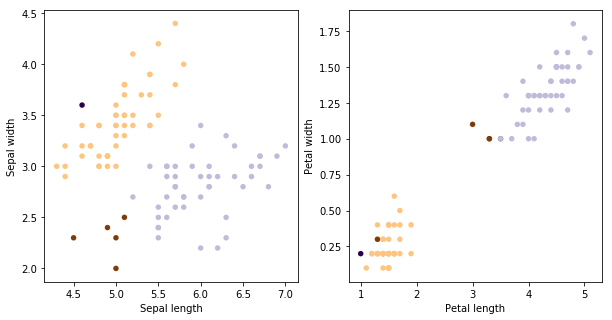

4


In [8]:
# Построим при найденных значениях гиперпараметров найденные алгоритмом кластеры
model = Clustering(eps=0.65, min_pts=7)
pred_iris = model.fit_predict(x_iris)

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

pl.show()

print(len(model.clusters))

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

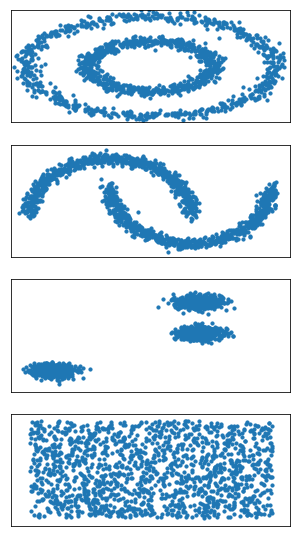

In [9]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

In [10]:
# Сравним реализацию DBSCAN из sklearn и нашу
eps = 0.6
min_pts = 7

model_sklearn_circles = sc.DBSCAN(eps=eps, min_samples=min_pts)
model_sklearn_moons = sc.DBSCAN(eps=eps, min_samples=min_pts)
model_sklearn_blobs = sc.DBSCAN(eps=eps, min_samples=min_pts)
model_sklearn_no_structure = sc.DBSCAN(eps=eps, min_samples=min_pts)

model_self_circles = Clustering(eps=eps, min_pts=min_pts)
model_self_moons = Clustering(eps=eps, min_pts=min_pts)
model_self_blobs = Clustering(eps=eps, min_pts=min_pts)
model_self_no_structure = Clustering(eps=eps, min_pts=min_pts)

x_circles = noisy_circles[0]
x_moons = noisy_moons[0]
x_blobs = blobs[0]
x_no_structure = no_structure[0]

pred_sklearn_cirles = model_sklearn_circles.fit(x_circles).labels_.astype(np.int)
pred_sklearn_moons = model_sklearn_moons.fit(x_moons).labels_.astype(np.int)
pred_sklearn_blobs = model_sklearn_blobs.fit(x_blobs).labels_.astype(np.int)
pred_sklearn_no_structure = model_sklearn_no_structure.fit(x_no_structure).labels_.astype(np.int)

pred_self_circles = model_self_circles.fit_predict(x_circles)
pred_self_moons = model_self_moons.fit_predict(x_moons)
pred_self_blobs = model_self_blobs.fit_predict(x_blobs)
pred_self_no_structure = model_self_no_structure.fit_predict(x_no_structure)

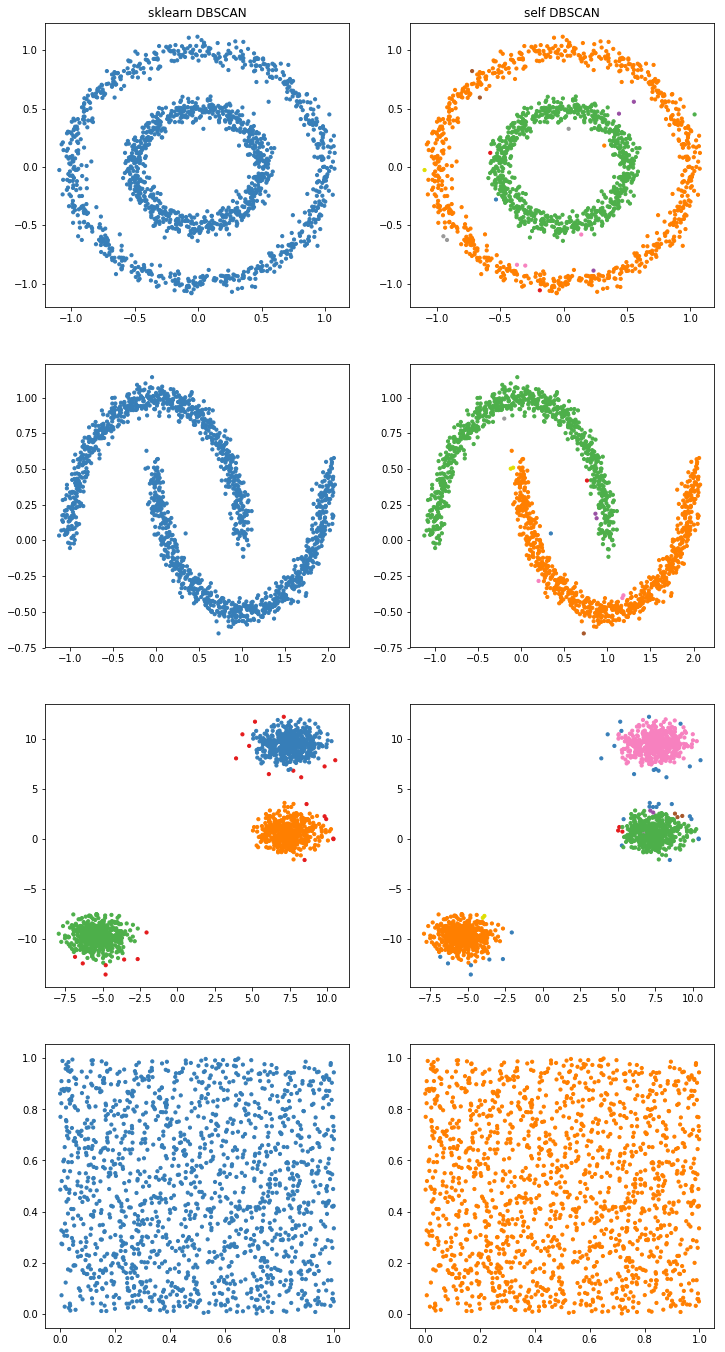

In [11]:
from itertools import cycle, islice

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(pred_self_circles) + 1))))

plt.figure(figsize=(12, 24))

pl.subplot(4, 2, 1)
pl.scatter(x_circles[:, 0], x_circles[:, 1], s=10, color=colors[pred_sklearn_cirles])
plt.title('sklearn DBSCAN')
pl.subplot(4, 2, 2)
pl.scatter(x_circles[:, 0], x_circles[:, 1], s=10, color=colors[pred_self_circles])
plt.title('self DBSCAN')

pl.subplot(4, 2, 3)
pl.scatter(x_moons[:, 0], x_moons[:, 1], s=10, color=colors[pred_sklearn_moons])
pl.subplot(4, 2, 4)
pl.scatter(x_moons[:, 0], x_moons[:, 1], s=10, color=colors[pred_self_moons])

pl.subplot(4, 2, 5)
pl.scatter(x_blobs[:, 0], x_blobs[:, 1], s=10, color=colors[pred_sklearn_blobs])
pl.subplot(4, 2, 6)
pl.scatter(x_blobs[:, 0], x_blobs[:, 1], s=10, color=colors[pred_self_blobs])

pl.subplot(4, 2, 7)
pl.scatter(x_no_structure[:, 0], x_no_structure[:, 1], s=10, color=colors[pred_sklearn_no_structure])
pl.subplot(4, 2, 8)
pl.scatter(x_no_structure[:, 0], x_no_structure[:, 1], s=10, color=colors[pred_self_no_structure])

pl.show()

По какой-то довольно загадочной причине реализация DBSCAN из библиотеки sklearn адекватно работает только на blobs... Наша реализация вроде бы работает на различных вариантах данных.